<a href="https://colab.research.google.com/github/New-AutoMotive/charger_stats/blob/main/01)%20Quarterly%20Charging%20Device%20Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DfT charging device statistics explore

### Initial set up
1. Install packages
2. Import visual design templates
3. Import packages for data importing, processing and analysis

#### Install packages

In [ ]:
# Run this block if running this notebook in Colab

!pip install odfpy
!pip install geopandas

#### Access New AutoMotive design templates

In [153]:
# Run this block ONLY if you are running this in Colab and have a New AutoMotive account to access the code for standard New AutoMotive graph designs. 
# Comment this block out if you are running this code and do not have access to New AutoMotive's files and are happy to accept standard Matplotlib designs. 

# BEFORE you run this code, make sure that a shortcut to the New AutoMotive shared folder is in your own google drive. 

from google.colab import drive
drive.mount('/content/drive')

import matplotlib as mpl
import pickle

with open('/content/drive/MyDrive/New AutoMotive/Data & Tech/Reference/Graph design files/design.pkl','rb') as f:
    set_params = pickle.load(f)

mpl.rcParams.update(set_params)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import packages

In [149]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import geopandas as gpd

tqdm.pandas()

import requests

from matplotlib import pyplot as plt

### Import & wrangle data

Importing and wrangling the data. We download the sheet from the link, then remove unnecessary bumpf on the spreadsheet.

There are three sheets in this dataset from DfT. See [here](https://www.gov.uk/government/statistics/electric-vehicle-charging-device-statistics-january-2022) for more information. 

In [89]:
df_01a = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1048354/electric-vehicle-charging-device-statistics-january-2022.ods', engine='odf', sheet_name='EVCD_01a')
df_01b = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1048354/electric-vehicle-charging-device-statistics-january-2022.ods', engine='odf', sheet_name='EVCD_01b')
df_02 = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1048354/electric-vehicle-charging-device-statistics-january-2022.ods', engine='odf', sheet_name='EVCD_02')

Import tables 01a and 01b:

In [90]:
# This function cleans up the first two sheets, the following function cleans up the last sheet

def df_cleaner(df):
    new_cols = df.iloc[5].tolist()
    new_cols[0] = 'lacd'
    new_cols[1] = 'lanm'
    new_cols = [str(x) for x in new_cols]
    new_cols = [x.replace(' 00:00:00', '') for x in new_cols]

    df.columns = new_cols
    df.drop(columns = ['nan'], inplace=True)
    df = df.iloc[7:]
    df = df.iloc[:429]
    return df

df_01a = df_cleaner(df_01a)
df_01b = df_cleaner(df_01b)

In [91]:
# Replace '-' with '0' and then convert all numbers to numeric data types.

for col in tqdm(df_01a.columns[2:]):
    df_01a[col] = df_01a[col].apply(lambda x: str(x).replace('-', '0'))
    df_01a[col] = pd.to_numeric(df_01a[col])

100%|██████████| 10/10 [00:00<00:00, 488.02it/s]


Import table 02

In [92]:
new_cols = df_02.iloc[5]
df_02.columns = new_cols
df_02 = df_02.iloc[6:35, :4]
df_02['Year'].fillna(method = 'ffill', inplace=True)
df_02.reset_index(inplace=True, drop=True)
df_02 = df_02.reindex(index=df_02.index[::-1])
df_02['Date'] = df_02.apply(lambda row: str(row['Year'])+'-'+row['Month'], axis=1)
df_02['Date'] = pd.to_datetime(df_02.Date)
# df_02.set_index('Date', inplace=True)
df_02.drop(columns=['Year', 'Month'], inplace=True)

### Analysing overall charger uptake

First, let's look at the number of chargers overall. 

`df_02` contains the number of rapid chargers installed every quarter. 

In [93]:
# We get the rate of installations in each quarter by first calculating the additional chargers installed in between each statistical release. 
# Sorting by date, we get the latest statistical release at the bottom, and the earliest statistical release (Q2 2015) at the top. 

df_02_rate = df_02.copy()
df_02_rate['time_diff'] = df_02_rate.sort_values('Date', ascending=True)['Date'].diff()
df_02_rate['total_d_diff'] = df_02_rate.sort_values('Date', ascending=True)['Total Devices'].diff()
df_02_rate['rapids_diff'] = df_02_rate.sort_values('Date', ascending=True)['Rapid Devices'].diff()
df_02_rate.dropna(inplace=True)

df_02_rate.head()

5,Total Devices,Rapid Devices,Date,time_diff,total_d_diff,rapids_diff
28,28375,5156,2022-01-01,92 days,2448,233
27,25927,4923,2021-10-01,92 days,1553,372
26,24374,4551,2021-07-01,91 days,1584,292
25,22790,4259,2021-04-01,90 days,2015,379
24,20775,3880,2021-01-01,92 days,1288,350


In [94]:
# We calculate the chargers installed per day:

# Convert the time delta to a number
df_02_rate['num_days'] = df_02_rate.time_diff.dt.days

df_02_rate['total_daily'] = df_02_rate.apply(lambda row: row['total_d_diff'] / row['num_days'], axis=1)
df_02_rate['rapids_daily'] = df_02_rate.apply(lambda row: row['rapids_diff'] / row['num_days'], axis=1)

In [95]:
df_02_rate.set_index('Date', inplace=True)

In [96]:
df_02_rate.head()

5,Total Devices,Rapid Devices,time_diff,total_d_diff,rapids_diff,num_days,total_daily,rapids_daily
Date,,,,,,,,
2022-01-01,28375,5156,92 days,2448,233,92,26.608696,2.532609
2021-10-01,25927,4923,92 days,1553,372,92,16.880435,4.043478
2021-07-01,24374,4551,91 days,1584,292,91,17.406593,3.208791
2021-04-01,22790,4259,90 days,2015,379,90,22.388889,4.211111
2021-01-01,20775,3880,92 days,1288,350,92,14.000000,3.804348


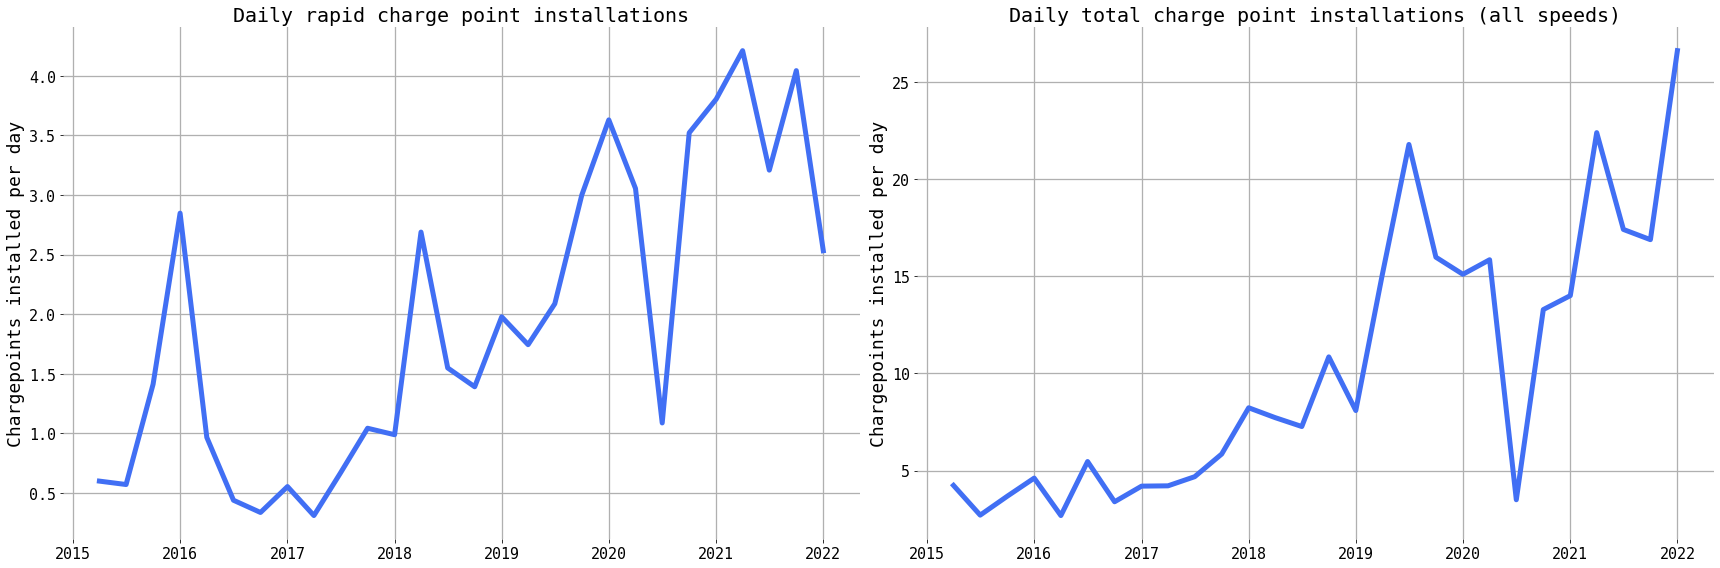

In [154]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(df_02_rate.rapids_daily)
ax1.set_title('Daily rapid charge point installations')
ax1.set_ylabel('Chargepoints installed per day')

ax2.plot(df_02_rate.total_daily)
ax2.set_title('Daily total charge point installations (all speeds)')
ax2.set_ylabel('Chargepoints installed per day')

plt.savefig('daily_charger_installations.png')
plt.show()

### Investigating the local authority districts with the most chargepoints

Digging deeper into regional trends.

The DfT spreadsheet unhelpfully has nations, regions, upper-tier and lower-tier LAs mixed in all together, creating repeats of the data and all sorts of annoying mess. Here we'll sort this out by getting a definitive list of LAD districts and UK regions from the ONS's Geoportal Statistics API. 

Obtain a list of all local authorities and regions, and their codes first:


In [106]:
# This downloads a lookup from ONS Geoportal Statistics which has lists of region codes and LAD codes, so we can separate out the DfT data.
# The below link was created using the Geoportal Statistics API explorer.
r = requests.get('https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/LAD21_RGN21_EN_LU/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json')
lookup = r.json()
# Convert the data into a DataFrame, accessing the 'features' bit of the dictionary which has the data inside it. 
df_lad = pd.json_normalize(lookup['features'])
# Give the columns clearer names
df_lad.columns = ['lad21cd', 'lad21nm', 'rgn21cd', 'rgn21nm', 'fid']

In [167]:
# Inspecting the lookup to see what we've got
df_lad.head()

,lad21cd,lad21nm,rgn21cd,rgn21nm,fid
0,E06000001,Hartlepool,E12000001,North East,1
1,E06000011,East Riding of Yorkshire,E12000003,Yorkshire and The Humber,2
2,E06000002,Middlesbrough,E12000001,North East,3
3,E06000003,Redcar and Cleveland,E12000001,North East,4
4,E06000012,North East Lincolnshire,E12000003,Yorkshire and The Humber,5


In [108]:
# df_lad = pd.read_csv('Local_Authority_District_to_Region_(April_2021)_Lookup_in_England.csv')
lad_codes = df_lad.lad21cd.unique().tolist()
region_codes = df_lad.rgn21cd.unique().tolist()

In [115]:
# Filter out any non-LAD areas, e.g. Regions and Nations
df_01a_lad = df_01a[df_01a.lacd.isin(lad_codes)]
df_01a_lad_cp = df_01a_lad.copy()

In [116]:
# Calculate recent increases
df_01a_lad['Q4_2021'] = df_01a_lad.apply(lambda row: row['2022-01-01'] - row['2021-10-01'], axis=1)
df_01a_lad['2021'] = df_01a_lad.apply(lambda row: row['2022-01-01'] - row['2021-01-01'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [117]:
# The largest quarterly increase in chargepoints happened in these LADs

df_01a_lad.sort_values('Q4_2021', ascending=False).head(10)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021
247,E09000005,Brent,485,237,203,236,233,211,211,209,206,207,248,252
256,E09000018,Hounslow,419,282,268,266,261,256,262,258,226,227,137,158
235,E09000020,Kensington and Chelsea,658,547,547,515,420,309,309,306,277,163,111,238
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126
261,E09000029,Sutton,128,51,55,55,52,49,48,49,47,46,77,76
245,E09000003,Barnet,287,210,197,175,139,139,136,137,135,68,77,148
258,E09000024,Merton,263,199,197,173,168,157,154,153,120,118,64,95
231,E09000012,Hackney,197,139,136,135,134,130,128,128,127,126,58,63
238,E09000025,Newham,210,153,120,120,100,102,97,95,95,83,57,110
242,E09000033,Westminster,1147,1095,1059,1021,646,556,575,570,527,485,52,501


In [118]:
# The largest yearly increase in chargepoints happened in these LADs

df_01a_lad.sort_values('2021', ascending=False).head(10)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021
242,E09000033,Westminster,1147,1095,1059,1021,646,556,575,570,527,485,52,501
247,E09000005,Brent,485,237,203,236,233,211,211,209,206,207,248,252
235,E09000020,Kensington and Chelsea,658,547,547,515,420,309,309,306,277,163,111,238
163,E08000026,Coventry,485,481,456,296,260,256,203,184,170,156,4,225
232,E09000013,Hammersmith and Fulham,598,580,554,528,386,374,316,301,291,274,18,212
239,E09000028,Southwark,438,390,357,328,267,249,199,195,191,154,48,171
256,E09000018,Hounslow,419,282,268,266,261,256,262,258,226,227,137,158
245,E09000003,Barnet,287,210,197,175,139,139,136,137,135,68,77,148
240,E09000030,Tower Hamlets,214,190,182,167,78,79,79,79,79,78,24,136
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126


In [119]:
# Calculate increase as a percentage of existing chargepoints

df_01a_lad['quart_perc_inc'] = df_01a_lad.apply(lambda row: row['Q4_2021']/row['2021-10-01'] if row['2021-10-01'] > 0 else 0, axis=1)
df_01a_lad['year_perc_inc'] = df_01a_lad.apply(lambda row: row['2021']/row['2021-01-01'] if row['2021-01-01'] > 0 else 0, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [121]:
# Councils with the highest quarterly percentage increase

df_01a_lad.sort_values('quart_perc_inc', ascending=False).head(10)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021,quart_perc_inc,year_perc_inc
267,E06000035,Medway,44,17,18,18,16,16,16,15,14,15,27,28,1.588235,1.750000
261,E09000029,Sutton,128,51,55,55,52,49,48,49,47,46,77,76,1.509804,1.461538
247,E09000005,Brent,485,237,203,236,233,211,211,209,206,207,248,252,1.046414,1.081545
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126,0.854167,2.423077
203,E07000095,Broxbourne,32,18,10,7,7,7,6,7,6,6,14,25,0.777778,3.571429
279,E07000062,Hastings,25,15,14,13,14,11,8,8,8,7,10,11,0.666667,0.785714
33,E07000027,Barrow-in-Furness,15,9,8,7,3,3,2,2,0,0,6,12,0.666667,4.000000
209,E07000243,Stevenage,15,9,11,11,11,9,6,6,6,6,6,4,0.666667,0.363636
281,E07000064,Rother,21,13,12,10,10,10,9,9,9,9,8,11,0.615385,1.100000
148,E07000193,East Staffordshire,32,20,21,20,19,17,15,15,14,12,12,13,0.600000,0.684211


In [122]:
# Councils with the highest yearly percentage increase

df_01a_lad.sort_values('year_perc_inc', ascending=False).head(10)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021,quart_perc_inc,year_perc_inc
33,E07000027,Barrow-in-Furness,15,9,8,7,3,3,2,2,0,0,6,12,0.666667,4.000000
116,E07000135,Oadby and Wigston,25,25,25,10,5,5,3,3,1,1,0,20,0.000000,4.000000
203,E07000095,Broxbourne,32,18,10,7,7,7,6,7,6,6,14,25,0.777778,3.571429
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126,0.854167,2.423077
299,E07000108,Dover,36,31,14,11,11,11,11,10,9,9,5,25,0.161290,2.272727
253,E09000015,Harrow,50,49,49,26,16,15,16,15,15,14,1,34,0.020408,2.125000
251,E09000010,Enfield,163,125,105,77,54,37,39,39,38,33,38,109,0.304000,2.018519
156,E07000218,North Warwickshire,39,33,28,28,13,12,12,12,10,8,6,26,0.181818,2.000000
214,E07000143,Breckland,50,41,33,28,18,18,16,16,16,15,9,32,0.219512,1.777778
158,E07000220,Rugby,58,53,45,21,21,18,15,15,4,3,5,37,0.094340,1.761905


### Regions

Here we have a look at the regions and nations that are installing charge points the fastest. 

In [169]:
# First we add some nation codes into our list of regions. 

region_codes.append('S92000003')
region_codes.append('W92000004')
region_codes.append('N92000002')

In [170]:
# Filter out any non-Region areas, e.g. LADs and Nations
df_01a_rgn = df_01a[df_01a.lacd.isin(region_codes)]
df_01a_rgn['Q4_2021'] = df_01a_rgn.apply(lambda row: row['2022-01-01'] - row['2021-10-01'], axis=1)
df_01a_rgn['2021'] = df_01a_rgn.apply(lambda row: row['2022-01-01'] - row['2021-01-01'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [171]:
# Calculate increase as a percentage of existing chargepoints

df_01a_rgn['quart_perc_inc'] = df_01a_rgn.apply(lambda row: row['Q4_2021']/row['2021-10-01'] if row['2021-10-01'] > 0 else 0, axis=1)
df_01a_rgn['year_perc_inc'] = df_01a_rgn.apply(lambda row: row['2021']/row['2021-01-01'] if row['2021-01-01'] > 0 else 0, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [172]:
df_01a_rgn_wd = df_01a_rgn.copy()

In [173]:
df_01a_rgn_wd.drop(columns=['lacd', 'quart_perc_inc', 'year_perc_inc', 'Q4_2021', '2021'], inplace=True)

In [174]:
df_01a_rgn_wd = df_01a_rgn_wd.T

In [175]:
df_01a_rgn_wd.columns = df_01a_rgn_wd.iloc[0]
df_01a_rgn_wd = df_01a_rgn_wd.iloc[1:]

In [176]:
df_01a_rgn_wd.index = pd.to_datetime(df_01a_rgn_wd.index)

In [177]:
df_01a_rgn_wd.columns = [x.title() for x in df_01a_rgn_wd.columns]

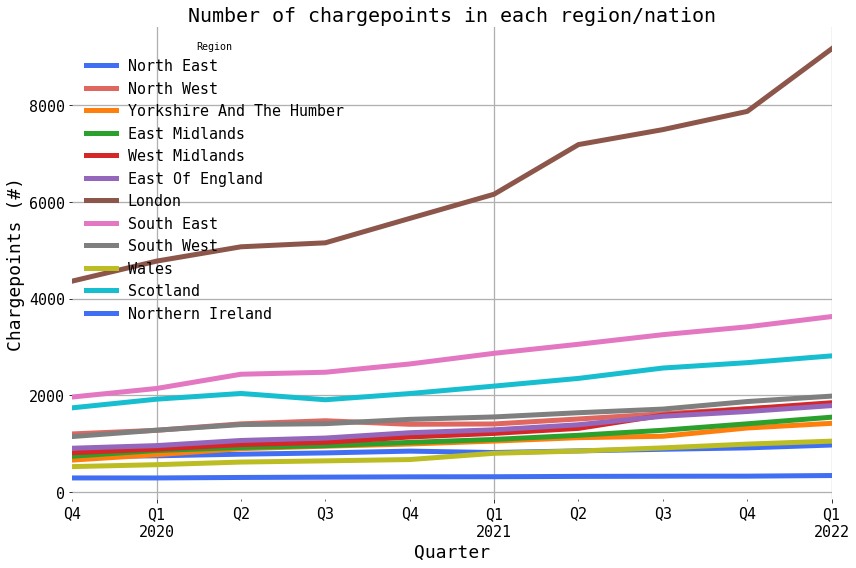

In [179]:
fig, ax = plt.subplots(figsize=(12, 8))

df_01a_rgn_wd.plot(ax=ax)
ax.set_title('Number of chargepoints in each region/nation')
ax.set_ylabel('Chargepoints (#)')
ax.set_xlabel('Quarter')
ax.legend(title='Region', loc='upper left')

plt.savefig('regional_charger_installs.png')
plt.show()